## **Medical Image Processing**
### Lab 3 - Deep Learning


In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ---------------------------------------------- Part #1 ----------------------------------------------

**1. Dataset extraction and visualization of a sample image**





In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Install required tools and libraries
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [4]:
# Directory that contains all the data/script of this lab
current_dir = '/content/drive/MyDrive/Colab Notebooks/eim/lab3'

In [5]:
import rarfile

# Set paths
rar_file_path = os.path.join(current_dir,"HAM1000.rar")
extract_folder = current_dir

# Create extraction folder if it doesn't exist
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Extract .rar file
with rarfile.RarFile(rar_file_path) as rar_ref:
    total_files = len(rar_ref.infolist())

    with tqdm(total=total_files, unit="file") as pbar:
        for member in rar_ref.infolist():
            rar_ref.extract(member, path=extract_folder)
            pbar.update(1)

print("Extraction completed!")

100%|██████████| 895/895 [05:16<00:00,  2.83file/s]

Extraction completed!


In [6]:
# List of training images with corresponding manual masks
image_folder = os.path.join('/content/drive/MyDrive/Colab Notebooks/eim/lab3/HAM1000','train','image')
mask_folder = os.path.join('/content/drive/MyDrive/Colab Notebooks/eim/lab3/HAM1000','train','manual')

list_images = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
list_masks = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])

# per controllo
print(f"Numero di immagini di training: {len(list_images)}")
print(f"Numero di maschere di training: {len(list_masks)}")

Numero di immagini di training: 205
Numero di maschere di training: 205


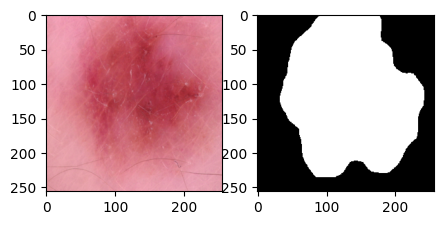

Immagine selezionata: ISIC_0024451.png
Dimensione immagine: (256, 256)
Dimensione maschera: (256, 256)


In [16]:
# Plot a random image with its corresponding mask
idx = np.random.randint(0, len(list_images))
image = Image.open(list_images[idx])
mask = Image.open(list_masks[idx])

fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(image)
ax[1].imshow(mask, cmap='gray')
plt.show()

# Stampa info utili
print(f"Immagine selezionata: {os.path.basename(list_images[idx])}")
print(f"Dimensione immagine: {image.size}")
print(f"Dimensione maschera: {mask.size}")

**2. Segmentation algorithm**

filtering -> equalization -> thresholding -> morphological operators -> largest connected component

*A. Gaussian filtering*

Immagine utilizzata: ISIC_0024431.png


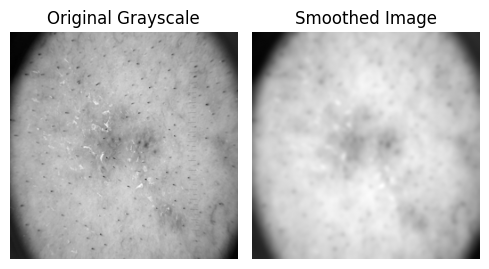

Image shape: (256, 256, 3)
Grayscale shape: (256, 256)


In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import color

# Select a random image
image_path = list_images[np.random.randint(0, len(list_images))]
print(f"Immagine utilizzata: {os.path.basename(image_path)}")

# Read the image and process it
image = np.array(Image.open(image_path))
gray_image = color.rgb2gray(image)
smoothed_image = gaussian_filter(gray_image, sigma=2)

# Display the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
ax1.imshow(gray_image,  cmap = 'gray')
ax1.set_title("Original Grayscale")
ax2.imshow(smoothed_image, cmap = 'gray')
ax2.set_title("Smoothed Image")

for ax in (ax1, ax2):
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Grayscale shape: {gray_image.shape}")

*B: Equalization*

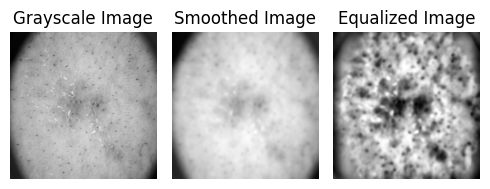

In [24]:
from skimage import exposure

# Adaptive histogram equalization
equalized_image = exposure.equalize_adapthist(smoothed_image, clip_limit=0.03)

# Display the processed images
fig, ax = plt.subplots(1, 3, figsize=(5, 3))

ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title("Grayscale Image")
ax[0].axis('off')

ax[1].imshow(smoothed_image, cmap='gray')
ax[1].set_title("Smoothed Image")
ax[1].axis('off')

ax[2].imshow(equalized_image, cmap='gray')
ax[2].set_title("Equalized Image")
ax[2].axis('off')

plt.tight_layout()
plt.show()

*C. Thresholding*

Threshold: 0.537109375


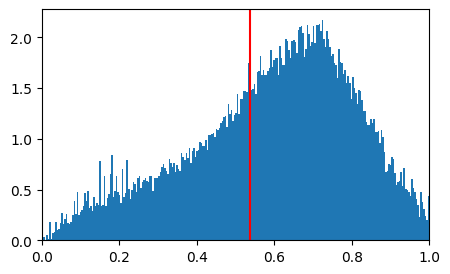

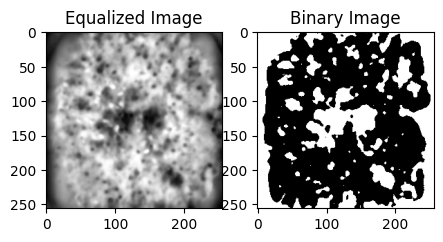

In [28]:
from skimage import filters

# Identify Otsu threshold
thresh = filters.threshold_otsu(equalized_image)
print("Threshold:", thresh)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(equalized_image.ravel(), bins=256, density=True)
ax.axvline(thresh, color='r')
ax.set_xlim([0, 1])
plt.show()

# Apply threshold to the image (the mask should be white over dark regions of the image)
binary_image = equalized_image < thresh

# Display the segmented image
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(equalized_image, cmap='gray')
ax[0].set_title("Equalized Image")
ax[1].imshow(binary_image, cmap='gray')
ax[1].set_title("Binary Image")
plt.show()

*D. Morphological operations and final segmentation*

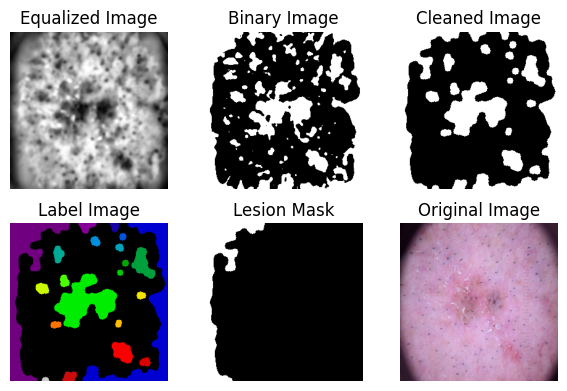

In [26]:
from skimage import filters, morphology, measure

# Apply morphological operations to clean the image
cleaned_image = morphology.binary_opening(
    morphology.binary_closing(binary_image, morphology.disk(5)),
    morphology.disk(5)
)

# Identify the largest connected component
label_image = measure.label(cleaned_image)
regions = measure.regionprops(label_image)
lesion_mask = label_image == (max(regions, key=lambda r: r.area).label if regions else 0)

# Display the results
fig, ax = plt.subplots(2, 3, figsize=(6, 4))

ax[0][0].imshow(equalized_image, cmap='gray')
ax[0][0].set_title("Equalized Image")
ax[0][0].axis('off')

ax[0][1].imshow(binary_image, cmap='gray')
ax[0][1].set_title("Binary Image")
ax[0][1].axis('off')

ax[0][2].imshow(cleaned_image, cmap='gray')
ax[0][2].set_title("Cleaned Image")
ax[0][2].axis('off')

ax[1][0].imshow(label_image, cmap='nipy_spectral')
ax[1][0].set_title("Label Image")
ax[1][0].axis('off')

ax[1][1].imshow(lesion_mask, cmap='gray')
ax[1][1].set_title("Lesion Mask")
ax[1][1].axis('off')

ax[1][2].imshow(image)
ax[1][2].set_title("Original Image")
ax[1][2].axis('off')

plt.tight_layout()
plt.show()


**3. Create a function that performs segmentation**

In [29]:
def get_lesion_mask(image_path):
    image = Image.open(image_path)

    # Convert image to NumPy array
    image_np = np.array(image)

    # Convert to grayscale
    gray_image = color.rgb2gray(image_np)

    # Apply Gaussian filter
    smoothed_image = gaussian_filter(gray_image, sigma=2)

    # Adaptive histogram equalization
    equalized_image = exposure.equalize_adapthist(smoothed_image, clip_limit=0.03)

    # Global thresholding using Otsu's method
    thresh = filters.threshold_otsu(equalized_image)
    binary_image = equalized_image < thresh

    # Morphological operations to clean the image
    cleaned_image = morphology.binary_opening(
        morphology.binary_closing(binary_image, morphology.disk(5)),
        morphology.disk(5)
    )

    # Identify the largest connected region
    label_image = measure.label(cleaned_image)
    regions = measure.regionprops(label_image)
    lesion_mask = label_image == (max(regions, key=lambda r: r.area).label if regions else 0)

    return lesion_mask

**4. Apply the segmentation algorithm to the images in the 'test' set**

In [35]:
# Paths to test images and corresponding manual masks
image_folder = os.path.join(current_dir, 'HAM1000','test','image')
mask_folder = os.path.join(current_dir, 'HAM1000','test','manual')

# Create list of image and mask file paths
list_images = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png'))])
list_masks = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(('.png'))])

# Define output folder for automatic masks
output_folder = os.path.join(extract_folder,'HAM1000','test','auto_masks')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for image_path in tqdm(list_images):

    # Get image filename
    image_name = os.path.basename(image_path)

    # Apply segmentation algorithm
    lesion_mask =  get_lesion_mask(image_path)
    lesion_mask_uint8 = (lesion_mask * 255).astype(np.uint8)
    lesion_mask = Image.fromarray(lesion_mask).convert('L')

    # Save generated mask to output folder
    lesion_mask_path = os.path.join(output_folder, image_name)
    lesion_mask.save(lesion_mask_path)

100%|██████████| 45/45 [00:05<00:00,  8.46it/s]


**5. Quantitative metrics calculation for segmentation quality**

In [36]:
def compute_binary_metrics(manual_mask, auto_mask):

    # Convert masks to boolean arrays
    manual_mask = manual_mask > 0
    auto_mask = auto_mask > 0

    # Check that masks have the same shape
    assert manual_mask.shape == auto_mask.shape, "Masks must have the same shape"

    # True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = np.sum(manual_mask & auto_mask)
    FP = np.sum(~manual_mask & auto_mask)
    TN = np.sum(~manual_mask & ~auto_mask)
    FN = np.sum(manual_mask & ~auto_mask)

    epsilon = 1e-7

    IoU = TP / (TP + FP + FN + epsilon)
    Dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    Precision = TP / (TP + FP + epsilon)
    Recall = TP / (TP + FN + epsilon)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)

    return IoU, Dice, Precision, Recall, Accuracy

**6. Metrics calculation for the test set**

45it [00:00, 70.30it/s]



SEGMENTATION METRICS - TEST SET
IoU:       mean = 0.4847, std = 0.2595
Dice:      mean = 0.6026, std = 0.2921
Precision: mean = 0.5638, std = 0.3060
Recall:    mean = 0.7124, std = 0.3333
Accuracy:  mean = 0.8221, std = 0.1088


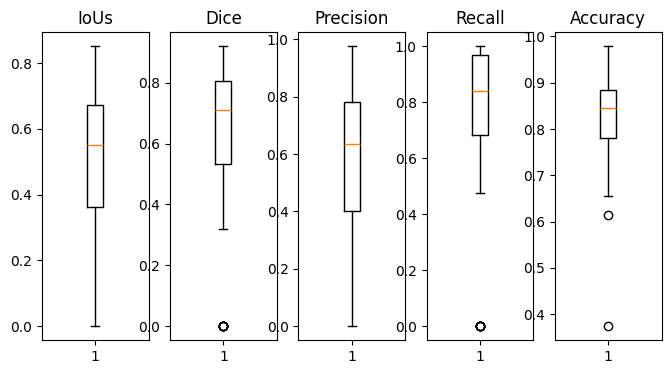

In [41]:
# List of test images with their manual and automatic masks
path_mask_manual = os.path.join(current_dir, 'HAM1000','test','manual')
path_mask_auto = os.path.join(current_dir, 'HAM1000','test','auto_masks')
list_mask_manual = sorted([os.path.join(path_mask_manual, f) for f in os.listdir(path_mask_manual) if f.endswith(('.png'))])
list_mask_auto =  sorted([os.path.join(path_mask_auto, f) for f in os.listdir(path_mask_auto) if f.endswith(('.png'))])

# Initialize metrics lists
IoUs, Dices, Precisions, Recalls, Accuracies = [], [], [], [], []

for manual_mask_path, auto_mask_path in tqdm(zip(list_mask_manual, list_mask_auto)):

    # Load masks
    manual_mask = np.array(Image.open(manual_mask_path))
    auto_mask = np.array(Image.open(auto_mask_path))

    # Compute metrics
    IoU, Dice, Precision, Recall, Accuracy = compute_binary_metrics(manual_mask, auto_mask)

    # Append metrics to lists
    IoUs.append(IoU)
    Dices.append(Dice)
    Precisions.append(Precision)
    Recalls.append(Recall)
    Accuracies.append(Accuracy)

# Print mean and standard deviation of metrics
print("\n" + "="*60)
print("SEGMENTATION METRICS - TEST SET")
print("="*60)
print(f"IoU:       mean = {np.mean(IoUs):.4f}, std = {np.std(IoUs):.4f}")
print(f"Dice:      mean = {np.mean(Dices):.4f}, std = {np.std(Dices):.4f}")
print(f"Precision: mean = {np.mean(Precisions):.4f}, std = {np.std(Precisions):.4f}")
print(f"Recall:    mean = {np.mean(Recalls):.4f}, std = {np.std(Recalls):.4f}")
print(f"Accuracy:  mean = {np.mean(Accuracies):.4f}, std = {np.std(Accuracies):.4f}")
print("="*60)

# Create boxplots for the metrics
fig, ax = plt.subplots(1, 5, figsize=(8, 4))
ax[0].boxplot(IoUs)
ax[0].set_title("IoUs")
ax[1].boxplot(Dices)
ax[1].set_title("Dice")
ax[2].boxplot(Precisions)
ax[2].set_title("Precision")
ax[3].boxplot(Recalls)
ax[3].set_title("Recall")
ax[4].boxplot(Accuracies)
ax[4].set_title("Accuracy")
plt.show()